In [1]:
#%%  American option
import numpy as np
import pandas as pd
T=1
S0=10
mu=0.05
sigma=0.2
sigma1=0.2
r=0.02
N=5000
K = 10
option_type='put'

#sigma1 = 0.2 ## realized volaility for the last question

In [2]:
#%% under Q probability space
deltat = T/N
u = np.exp(r * deltat + sigma * np.sqrt(deltat))  ##from the model assumptiop, different with CRR
d = np.exp(r * deltat - sigma * np.sqrt(deltat))
pu = (np.exp(r * deltat) - d)/(u-d)  ### pu is equivalent to Q in 2nd question
pd = 1 - pu

##### Calculate American option price
Define a price N+1 * N+1 matrix, and use the upper triangle to simulte price and value

In [3]:
price_matrix = np.zeros([N+1,N+1]) #Save stock price
price_matrix[:] = np.nan
price_matrix[0,0] = S0
for i in range(0,N):
    price_matrix[0:(i+1),i+1] = price_matrix[0:(i+1),i] * u
    price_matrix[i+1,i+1] = price_matrix[i,i] * d  

def value_matrix_calculation(price_matrix, N, option_type, pu, pd):
    ##N is steps
    value_matrix = np.zeros_like(price_matrix)
    value_matrix[:] = np.nan
    if option_type == 'put':
        value_matrix[0:N+1,N] =  np.where((K - price_matrix[0:N+1,N])>0,K - price_matrix[0:N+1,N],0)# european put option
        for i in range(N,0,-1):
            temporary_value = np.exp(-r * deltat) * (pu * value_matrix[0:i,i] + pd * value_matrix[1:(i+1),i])#hold value
            price_value = np.where((K - price_matrix[0:i,i-1]) >= 0,K- price_matrix[0:i,i-1],0)#exercise value
            value_matrix[0:i,i-1] = np.where(temporary_value > price_value,temporary_value,price_value)#american option value at each time step 
    elif option_type == 'call':
        value_matrix[0:N+1,N] =  np.where((price_matrix[0:N+1,N] - K )>0,price_matrix[0:N+1,N] - K,0)
        for i in range(N,0,-1):
            temporary_value = np.exp(-r * deltat) * (pu * value_matrix[0:i,i] + pd * value_matrix[1:(i+1),i])
            price_value = np.where((price_matrix[0:i,i-1] - K) >= 0,price_matrix[0:i,i-1]- K,0)
            value_matrix[0:i,i-1] = np.where(temporary_value > price_value ,temporary_value, price_value )
    else:
        Warning('option type error')
    return value_matrix
value_matrix = value_matrix_calculation(price_matrix,N,'put',pu,pd)#american option value

#### find exercise boundary of American put option
Compare the value_matrix with (K - price_matrix) to determine whether it's optimal to exercise now.


In [4]:
execute_price_matrix = np.zeros_like(price_matrix)
execute_price_matrix[:] = np.nan
for i in range(N+1):
    price_value = np.where((K - price_matrix[0:(i+1),i]) >= 0, K- price_matrix[0:(i+1),i],0)#Value for exercising the option
    
    execute_price_matrix[:(i+1),i] = np.where(value_matrix[:(i+1),i] > price_value, np.nan, price_value )
    ##if price_value== value_matrix, indicates that we should execute option now, otherwise, value_matrix > price_value
    
## find the first price which price_value=option_value
execute_price = np.zeros(N+1)
execute_price[:] = np.nan
for j in range(N+1): ##j is columns
    for i in range(N+1):  ## i is rows
        if(execute_price_matrix[i, j] > 0):
            execute_price[j] = K - execute_price_matrix[i,j]
            break

Text(0.5,1,'Boundary Price when $\\sigma=0.2,r=0.02$')

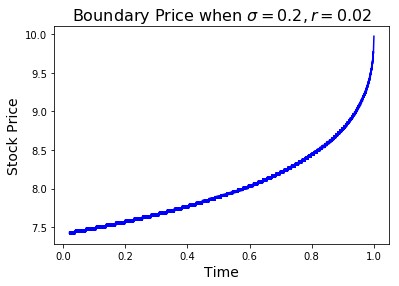

In [6]:

import matplotlib.pyplot as plt
import os

plt.plot(T * np.array(range(N+1))/N,execute_price,'b-',label = 'Exercise Price')
plt.xlabel('Time',fontdict={'fontsize':14})
plt.ylabel('Stock Price',fontdict={'fontsize':14})
plt.title('Boundary Price when $\sigma={},r={}$'.format(sigma,r),fontdict={'fontsize':16})
#plt.savefig('Exercise Price for Ameriance Option sigma=02_r=002')

In [7]:
#%% under real probabiility space

np.random.seed(4)
realpu = (1+((mu-r)-sigma1**2/2)*np.sqrt(deltat)/sigma1)/2

##Geberate stock price based on CRR model
simulate = np.random.binomial(1,realpu,(N+1,10000))*2 -1  ## construct  10000 simulation,each with 5000 steps
simulate = np.exp(r * deltat + simulate * sigma1 * np.sqrt(deltat))  ## multiplier
simulate[0,:] =  S0  # Initialize the price; 
simulate_price = simulate.cumprod(axis=0)   ## each column is a price path

stop_values = []
stop_steps = []
for i in range(10000):
    cross_path = simulate_price[:,i] <= execute_price  ##check if this path crossed the execution boundary
    if cross_path.any():
        current_step = np.where(cross_path)[0][0]#The first cross for each simulated path
        stop_steps.append( current_step )
        stop_values.append( K - execute_price[current_step] )#American option value at each stop
    else:
        stop_steps.append(np.nan)
        stop_values.append(0) 

E:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


Text(0.5,1,'Profit Kernel Density')

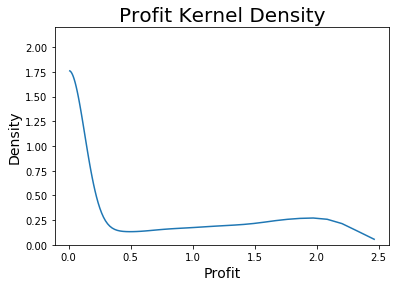

In [8]:
## kernel estimation
from scipy.stats import gaussian_kde
#stop_values = np.array(stop_values)[np.array(stop_values)>0]   ##consider those value>0
kernel = gaussian_kde(stop_values)
x_grid = np.logspace(-2,np.log10(np.max(stop_values)),num = 100)
plt.figure()
plt.plot(x_grid,kernel.evaluate(x_grid))
plt.ylim([0,2.2])
plt.xlabel('Profit',fontdict={'fontsize':14})
plt.ylabel('Density',fontdict={'fontsize':14})
plt.title('Profit Kernel Density',fontdict={'fontsize':20})

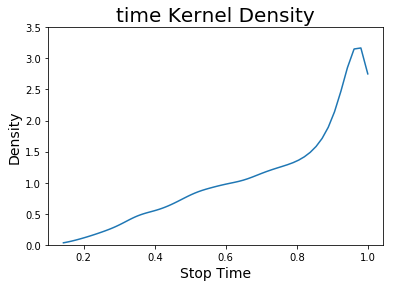

In [9]:
stop_time = T * np.array(stop_steps)[~np.isnan(stop_steps)]/N  ##eliminate those don't touch the boundary   tau = T - deltaT
kernel_step= gaussian_kde(stop_time)
grid = np.logspace(np.log10(min(stop_time)),np.log10(max(stop_time)),num=100)
plt.figure()
plt.plot(grid,kernel_step.evaluate(grid))
plt.ylim([0,3.5])
plt.xlabel('Stop Time',fontdict={'fontsize':14})
plt.ylabel('Density',fontdict={'fontsize':14})
plt.title('time Kernel Density',fontdict={'fontsize':20})
plt.savefig('time kernel distribution')
